In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

'''import kagglehub
borismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')
print('Data source import complete.')'''

"import kagglehub\nborismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')\nprint('Data source import complete.')"

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [2]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

'''# Time series decomposition
!pip install stldecompose
from stldecompose import decompose
'''
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [3]:
import FinanceDataReader as fdr

start_date = '2011-01-01'
end_date = '2020-12-31'

df = fdr.DataReader('KS11', start_date, end_date)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df.head()

Date     Open     High      Low    Close     Volume  Change  UpDown  \
0 2011-01-03  2063.69  2070.09  2054.83  2070.08  354083359  0.0093       1   
1 2011-01-04  2074.56  2085.14  2069.12  2085.14  415906517  0.0073       1   
2 2011-01-05  2083.10  2087.14  2076.92  2082.55  386064920 -0.0012       2   
3 2011-01-06  2094.35  2096.65  2066.10  2077.61  407829146 -0.0024       2   
4 2011-01-07  2073.68  2086.20  2068.66  2086.20  335558949  0.0041       1   

    Comp         Amount            MarCap  
0  19.08  5941470649203  1153204185044950  
1  15.06  7799740341295  1163384106084700  
2  -2.59  8609366845145  1162008605708700  
3  -4.94  8804441828186  1159300878918060  
4   8.59  7675864506306  1164242711087020

### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

In [5]:
'''df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)'''

"df_close = df[['Date', 'Close']].copy()\ndf_close = df_close.set_index('Date')\ndf_close.head()\n\ndecomp = decompose(df_close, period=365)\nfig = decomp.plot()\nfig.set_size_inches(20, 8)"

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [6]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [7]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [8]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [9]:
df['Close'] = df['Close'].shift(-1)

### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [10]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [11]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [12]:
features = ['EMA_9','SMA_5','SMA_10','SMA_15','SMA_30','RSI','MACD','MACD_signal','Close']

train_df = train_df[features]
valid_df = valid_df[features]
test_df = test_df[features]

### Split into features and labels

In [13]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1701 non-null   float64
 1   SMA_5        1701 non-null   float64
 2   SMA_10       1701 non-null   float64
 3   SMA_15       1701 non-null   float64
 4   SMA_30       1701 non-null   float64
 5   RSI          1701 non-null   float64
 6   MACD         1701 non-null   float64
 7   MACD_signal  1701 non-null   float64
dtypes: float64(8)
memory usage: 106.4 KB


### Fine-tune XGBoostRegressor

In [14]:
'''%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbose=False, verbosity=0)
clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
print(f'Best RMSE: {np.sqrt(-clf.best_score_)}')'''

"%%time\n\nparameters = {\n    'n_estimators': [100, 200, 300, 400],\n    'learning_rate': [0.001, 0.005, 0.01, 0.05],\n    'max_depth': [8, 10, 12, 15],\n    'gamma': [0.001, 0.005, 0.01, 0.02],\n    'random_state': [42]\n}\n\nmodel = xgb.XGBRegressor(objective='reg:squarederror', verbose=False, verbosity=0)\nclf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')\n\nclf.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose=False)\n\nprint(f'Best params: {clf.best_params_}')\nprint(f'Best validation score = {clf.best_score_}')\nprint(f'Best RMSE: {np.sqrt(-clf.best_score_)}')"

In [16]:
%%time

parameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01],
    'max_depth': [12, 15],
    'gamma': [0.001, 0.01],
    'random_state': [42]
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbose=False, verbosity=0)
clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
print(f'Best RMSE: {np.sqrt(-clf.best_score_)}')

Best params: {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 200, 'random_state': 42}
Best validation score = -14521.330936523122
Best RMSE: 120.50448513031837
CPU times: total: 18min 26s
Wall time: 3min 37s


In [17]:
%%time
eval_set = [(X_train, y_train),(X_valid, y_valid)]
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: total: 29.2 s
Wall time: 3.08 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.001, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

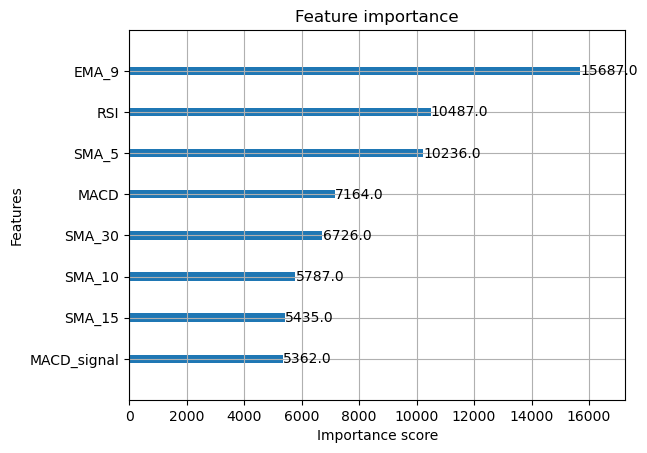

In [18]:
plot_importance(model);

### Calculate and visualize predictions

In [19]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [2086.66 2082.48 2091.87 2072.92 2066.55]
y_pred = [2056.8591 2058.602  2049.7903 2063.5847 2058.5027]


In [20]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 10699.185664349674


In [21]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()